## Make multiwavelength light curves using archival data

### Summary:
 - model plots after van Velzen et al. 2021, https://arxiv.org/pdf/2111.09391.pdf
 
### Input:
 - a catalog of CLAGN from the literature

### Output:
 - an archival optical + IR + neutrino light curve
 
### Technical Goals:
 - should be able to run from a clean checkout from github
 - should be able to automatically download all catalogs & images used
 - need to have all photometry in the same physical unit
 - need to have a data structure that is easy to use but holds light curve information (time and units) and is extendable to ML applications
 - need to have a curated list of catalogs to search for photometry that is generalizeable to other input catalogs
 
### Authors:
IPAC SP team

### Acknowledgements:
Suvi Gezari, Antara Basu-zych,
MAST, HEASARC, & IRSA Fornax teams

In [300]:
import numpy as np
import time

import os

from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack, hstack
from astropy.io import fits, ascii
from astropy.time import Time
from astropy.timeseries import TimeSeries

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects


## Plotting stuff
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['xtick.major.pad'] = 7
mpl.rcParams['ytick.major.pad'] = 7
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['ytick.minor.left'] = True
mpl.rcParams['ytick.minor.right'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['hatch.linewidth'] = 1
def_cols = plt.rcParams['axes.prop_cycle'].by_key()['color']


## From Brigitta
class MultibandTimeSeries(TimeSeries):
    def __init__(self, *, data=None, time=None, **kwargs):
        # using kwargs to swallow all other arguments a TimeSeries/QTable can have,
        # but we dont explicitly use. Ideally they are spelt out if we have docstrings here.
        # Also using keyword only arguments everywhere to force being explicit.
        super().__init__(data=data, time=time, **kwargs)
                
    def add_band(self, *, time=None, data=None, band_name="None"):
        '''Add a time, flux/mag data set and resort the arrays. ``time`` can be a TimeSeries instance'''
        if 'time' not in self.colnames:
            if isinstance(time, TimeSeries):
                super().__init__(time)
            else:
                super().__init__(data={band_name: data}, time=time)
        else:
            if time is None:
                # this assumes ``band_name`` fluxes are taken at the very same times as the already exitsing bands
                # TODO: include checks for sizes and other assumptions
                self[band_name] = data
                return 
            elif not isinstance(time, TimeSeries):
                # TODO: handle band_name=None case
                time = TimeSeries(time=time, data={band_name: data})
            super().__init__(vstack([self, time]))

## 1. Define the Sample

In [2]:
# use the following paper to make a sample of CLAGN: https://iopscience.iop.org/article/10.3847/1538-4357/aaca3a 

# This sample can later be switched out to a differen/larger sample of "interesting" targets

#use ADS to find the refcode for this paper
CLAGN = Ned.query_refcode('2018ApJ...862..109Y')


### What is the best data structure for this work?
 - needs to hold multiwavelength light curves
 - understands both time and units on fluxes
 - would like to know if whatever we choose can be scaled up to make light curves of the while WISE sample
 - some things to look into
     - astropy has a light curve class
         -would probably need to do some development work to make this work for multiwavelength application
     - LINCC people are interested in this and might have some suggestions on a 6mo. timescale
     - xarray
     - pandas might have more unit support now than before
     - what is ZTF using?
     - what did Dave do in his WISE parquet files?
     
- One suggestion is that instead of one large dataframe with the multiwavelength information, we keep them as seperate astropy light curves for each band, do the feature extraction on each light curve and keep the features in one large dataframe.

In [3]:
type(CLAGN)

astropy.table.table.Table

In [4]:
#### Build a list of skycoords from target ra and dec #####
coords_list = [
    SkyCoord(ra, dec, frame='icrs', unit='deg')
    for ra, dec in zip(CLAGN['RA'], CLAGN['DEC'])
]


## 2. Find photometry for these targets in NASA catalogs
- look at NAVO use cases to get help with tools to do this - although they mostly use pyvo
- deciding up front to use astroquery instead of pyvo
    - astroquery is apparently more user friendly
- data access concerns:
    - can't ask the archives to search their entire holdings
        - not good enough meta data
        - not clear that the data is all vetted and good enough to include for science
        - all catalogs have differently named columns so how would we know which columns to keep
    - instead work with a curated list of catalogs for each archive
        - focus on general surveys
        - try to ensure that this list is also appropriate for a generalization of this use case to other input catalogs
        - could astroquery.NED be useful in finding a generalized curated list
- How do we know we have a match that is good enough to include in our light curve
     - look at nway for the high energy catalogs
     - probably need to generate a table of search radii for each catalog based on bandpass
         - need domain knowledge for that
     


### HEASARC (Krick)
- asked Antara for help making a curated list of catalogs
- Suvi mentioned scientifically sensible to include Fermi Gamma ray photometry

In [ ]:
#list all the available HEASARC missions
heasarc = Heasarc()
mission_table = heasarc.query_mission_list()
#mission_table.pprint_all()



In [ ]:
#figure out what the column names are in one of the catalogs
cols = heasarc.query_mission_cols(mission='fermi3fgl')
#cols


In [ ]:
#For all CLAGN coords in the paper
c = 1 #just playing with astroquery query_region
#do a query on position
mission = 'fermi3fgl'
radius = 0.1*u.degree
results = heasarc.query_region(coords(c), mission = mission, radius = radius, sortvar = 'SEARCH_OFFSET_')
#if there is a good match where good = ??
#save the found photometry in the chosen data structure
        

### IRSA

astroquery.ipac.irsa 

 - need to make a curated list of catalogs here
     - ZTF (Faisst)
 
     - WISE (Krick)
         - use Dave Shupe's light curve catalog parquet file /irsa-data-download10/parquet-work/NEOWISE-R/neowise_lc_half.parquet
         - can use existing code in https://github.com/IPAC-SW/ipac-sp-notebooks/blob/main/catwise_variables/nhel_xgboost.ipynb to access and work with this catalog
         - will need to work on how to efficiently search that catalog since it is too big to fit in memory
             - re-do work on Vaex and Dask and Spark
         - Do we need updates to this catalog from Dave?
             - once concern is that it is only half sky, hopefully enough of our targets are in the catalog


### MAST (Krick)

- astroquery MAST doesn't require a catalog input but we might want it to narrow things down?
    - which catalogs are interesting?
        - Pan-STARRS
        - need to ask someone at MAST for a curated list of catalogs to search
        
- MAST has copies of ATLAS all-sky stellar reference catalog- but not searchable
     - might be available through astroquery.vizier
    


## 3. Find photometry for these targets in relevant, non-NASA catalogs


### Gaia (Faisst)
- astroquery.gaia will presumably work out of the box for this

We first get the median photometry by matching to the Gaia catalog. After that, we can use
the Gaia IDs to extract the light curves.

In [6]:
############ EXTRACT GAIA DATA FOR OBJECTS ##########
# First need to search the Gaia catalog and match to our objects.

## Select Gaia table (DR3)
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

## Define search radius
radius = u.Quantity(20, u.arcsec)

## Search and Cross match.
# This can be done in a smarter way by matching catalogs on the Gaia server, or grouping the
# sources and search a larger area.

# get catalog
gaia_table = Table()
t1 = time.time()
for cc,coord in enumerate(coords_list):
    print(len(coords_list)-cc , end=" ")

    gaia_search = Gaia.cone_search_async(coordinate=coord, radius=radius , background=True)
    gaia_search.get_data()["dist"].unit = "deg"
    gaia_search.get_data()["dist"] = gaia_search.get_data()["dist"].to(u.arcsec) # Change distance unit from degrees to arcseconds
    
    
    # match
    if len(gaia_search.get_data()["dist"]) > 0:
        gaia_search.get_data()["input_object_name"] = CLAGN["Object Name"][cc] # add input object name to catalog
        sel_min = np.where( (gaia_search.get_data()["dist"] < 1*u.arcsec) & (gaia_search.get_data()["dist"] == np.nanmin(gaia_search.get_data()["dist"]) ) )[0]
    else:
        sel_min = []
        
    #print("Number of sources matched: {}".format(len(sel_min)) )
    
    if len(sel_min) > 0:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )
    else:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )

print("\nSearch completed in {:.2f} seconds".format((time.time()-t1) ) )
print("Number of objects mached: {} out of {}.".format(len(gaia_table),len(CLAGN) ) )

31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 
Search completed in 76.60 seconds
Number of objects mached: 28 out of 31.


In [109]:
########## EXTRACT PHOTOMETRY #########
# Once we matched the objects, we have to extract the photometry for them. Here we extract
# the mean photometry (later we will do the time series).
# Note that the fluxes are in e/s, not very useful. However, there are magnitudes (what unit??) but without errors.
# We can get the errors from the flux errors?
# Also note that we should include the source_id in order to search for epoch photometry

## Define keys (columns) that will be used later. Also add wavelength in angstroms for each filter
other_keys = ["source_id","phot_g_n_obs","phot_rp_n_obs","phot_bp_n_obs"] # some other useful info
mag_keys = ["phot_bp_mean_mag" , "phot_g_mean_mag" , "phot_rp_mean_mag"]
magerr_keys = ["phot_bp_mean_mag_error" , "phot_g_mean_mag_error" , "phot_rp_mean_mag_error"]
flux_keys = ["phot_bp_mean_flux" , "phot_g_mean_flux" , "phot_rp_mean_flux"]
fluxerr_keys = ["phot_bp_mean_flux_error" , "phot_g_mean_flux_error" , "phot_rp_mean_flux_error"]
mag_lambda = ["5319.90" , "6735.42" , "7992.90"]

## Get photometry. Note that this includes only objects that are 
# matched to the catalog. We have to add the missing ones later.
_phot = gaia_table[mag_keys]
_err = hstack( [ 2.5/np.log(10) * gaia_table[e]/gaia_table[f] for e,f in zip(fluxerr_keys,flux_keys) ] )
gaia_phot2 = hstack( [_phot , _err] )

## Clean up (change units and column names)
_ = [gaia_phot2.rename_column(f,m) for m,f in zip(magerr_keys,fluxerr_keys)]
for key in magerr_keys:
    gaia_phot2[key].unit = "mag"
gaia_phot2["input_object_name"] = gaia_table["input_object_name"].copy()

## Add Some other useful information
for key in other_keys:
    gaia_phot2[key] = gaia_table[key]


## Also add object for which we don't have photometry.
# Add Nan for now, need to think about proper format. Also, there are probably smarter ways to do this.
# We do this by matching the object names from the original catalog to the photometry catalog. Then add
# an entry [np.nan, ...] if it does not exist. To make life easier, we add a dummy entry as the first
# row so we can compy all the 
gaia_phot = Table( names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
for ii in range(len(CLAGN)):
    sel = np.where( CLAGN["Object Name"][ii] == gaia_phot2["input_object_name"] )[0]
    if len(sel) > 0:
        gaia_phot = vstack([gaia_phot , gaia_phot2[sel] ])
    else:
        tmp = Table( np.repeat(np.NaN , len(gaia_phot2.keys())) , names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
        gaia_phot = vstack([gaia_phot , tmp ])
        
## Some cleanup:
gaia_phot["source_id"][gaia_phot["source_id"] < 0] = 0

In [330]:
######## EXTRACT LIGHT CURVES ##########
# Now since we have matched the objects to the Gaia catalog, we can also extract the full light curves using
# the Gaia IDs.

## Log in (apparently not necessary for small queries) =========
#Gaia.login(user=None , password=None)


## For each of the objects, request the EPOCH_PHOTOMETRY from the Gaia DataLink Service =======
# First we define two function, one to retrieve the photometry and one to make a nice light
# curve dictionary. We define another function to transform the epoch photometry tables into
# a MultiBandTimeSeries object.



## Define function to retrieve epoch photometry
def Gaia_retrieve_EPOCH_PHOTOMETRY(ids, verbose):
    '''
    Function to retrieve EPOCH_PHOTOMETRY (or actually any) catalog product for Gaia
    entries using the DataLink. Note that the IDs need to be DR3 source_id and needs to be a list.
    
    Code fragments taken from: https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products
    
    INPUT:
        - ids: List of Gaia DR3 source IDs (source_id). 
    
    OUTPUT:
        - Dictionary (key = source_id) with a table of photometry as a function of time
        
    '''
    
    ## Some Definitions
    retrieval_type = 'EPOCH_PHOTOMETRY'# Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
    data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
    data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'

    ## Get the files
    datalink = Gaia.load_data(ids=ids,
                              data_release = data_release,
                              retrieval_type=retrieval_type,
                              data_structure = data_structure, verbose = False, output_file = None , overwrite_output_file=True)
    dl_keys  = list(datalink.keys())
    
    if verbose:
        print(f'The following Datalink products have been downloaded:')
        for dl_key in dl_keys:
            print(f' * {dl_key}')
    
    ## Extract the info
    prod_tab = dict() # Dictionary to save the light curves. The key is the source_id
    for dd in ids:
        if verbose: print("{}: ".format(dd) , end=" ")
        this_dl_key = 'EPOCH_PHOTOMETRY-Gaia DR3 {}.xml'.format(dd)
        if this_dl_key in datalink.keys():
            prod_tab[str(dd)] = datalink[this_dl_key][0].to_table()
            if verbose: print("found")
        else:
            pass
            if verbose: print("not found")
    
    return(prod_tab)

## Define function to extract nice light curve from product table.
def Gaia_mk_lightcurves(prod_tab):
    '''
    This function creates light curves from the table downloaded with DataLink from the Gaia server.
    
    INPUT:
        - prod_tab: product table downloaded via datalink, produced by `Gaia_retrieve_EPOCH_PHOTOMETRY()`.
        
    OUTPUT:
        - A dictionary (key = source_id) including a dictionary of light curves for bands "G", "BP", "RP". Each
        of them includes a time stamp (`time_jd` and `time_isot`) a magnitude (`mag`) and magnitude error (`magerr`).
    '''
    
    bands = ["G","BP","RP"]
    output = dict()
    for ii,key in enumerate(list(prod_tab.keys()) ):
        print(key)
    
        output[str(key)] = dict()
        for band in bands:
            sel_band = np.where( (prod_tab[key]["band"] == band) & (prod_tab[key]["rejected_by_photometry"] == False) )[0]
            print("Number of entries for band {}: {}".format(band , len(sel_band)))
            
            time_jd = prod_tab[key][sel_band]["time"] + 2455197.5 # What unit???
            time_isot = Time(time_jd , format="jd").isot
            mag = prod_tab[key][sel_band]["mag"]
            magerr = 2.5/np.log(10) * prod_tab[key][sel_band]["flux_error"]/prod_tab[key][sel_band]["flux"]
            
            output[str(key)][band] = Table([time_jd , time_isot , mag , magerr] , names=["time_jd","time_isot","mag","magerr"] ,
                                           dtype = [float , str , float , float], units=[u.d , ""  , u.mag , u.mag])
            
    return(output)

## Function to add light curves into Multi-Band Time Series object
def Gaia_mk_MultibandTimeSeries(epoch_phot):
    '''
    Creates MultibandTimeSeries object from epoch photometry lightcurves
    
    INPUT
        - epoch_phot: Epoch photometry light curve (see `Gaia_mk_lightcurves`)
        
    OUTPUT
        - Dictionary of MultibandTimeSeries light curves (for each source_id)
    '''
    
    
    
    ## For each source, create a MultibandTimeSeries object and add the bands.
    bands = ["G","BP","RP"]
    out = dict()
    for key in epoch_phot.keys():
        
        # Initialize
        ts = MultibandTimeSeries()
        
        # Add bands
        for band in bands:
            ts.add_band(time = Time(epoch_phot[str(source_id)][band]["time_jd"] , format="jd") ,
                 data = epoch_phot[str(source_id)][band]["mag"],
                 band_name=band
                )
        out[key] = ts
        
    return(out)

## Run search
ids = list(gaia_phot["source_id"])
prod_tab = Gaia_retrieve_EPOCH_PHOTOMETRY(ids=ids , verbose=False)

## Create light curves
gaia_epoch_phot = Gaia_mk_lightcurves(prod_tab)

## Create MultiBandTimeSeries photometry object
gaia_multibandTS_phot = Gaia_mk_MultibandTimeSeries(epoch_phot = gaia_epoch_phot)


904082683004665984
Number of entries for band G: 27
Number of entries for band BP: 26
Number of entries for band RP: 26
795660322425388672
Number of entries for band G: 49
Number of entries for band BP: 40
Number of entries for band RP: 41
3804083732709918336
Number of entries for band G: 26
Number of entries for band BP: 25
Number of entries for band RP: 25
4027439177611191424
Number of entries for band G: 49
Number of entries for band BP: 34
Number of entries for band RP: 35
1576323954788254336
Number of entries for band G: 56
Number of entries for band BP: 48
Number of entries for band RP: 46
1684682543691923840
Number of entries for band G: 45
Number of entries for band BP: 41
Number of entries for band RP: 42
3658807529075031552
Number of entries for band G: 30
Number of entries for band BP: 29
Number of entries for band RP: 26
1281601065553105408
Number of entries for band G: 46
Number of entries for band BP: 42
Number of entries for band RP: 43
1373132896008893184
Number of entr

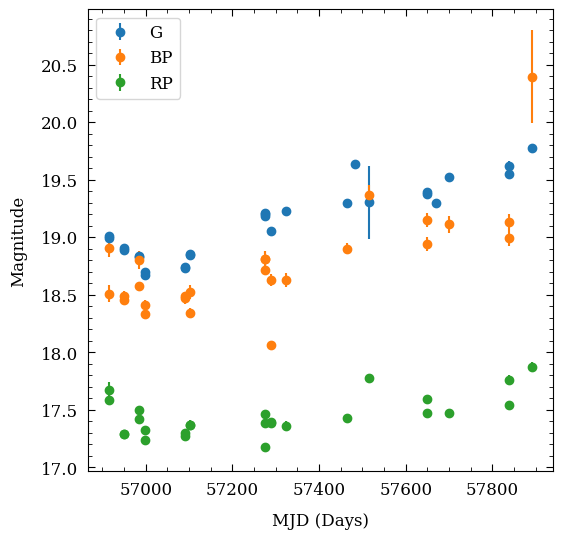

In [298]:
## MAKE A FIGURE OF ONE LIGHT CURVE ###
# Make a figure of one of the light curves in all the bands.
source_id = 904082683004665984

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)

for band in ["G","BP","RP"]:
    d = gaia_epoch_phot[str(source_id)][band]["time_isot"]
    t = Time(d , format="isot") # convert to time object
    ax1.errorbar(t.mjd , gaia_epoch_phot[str(source_id)][band]["mag"] , yerr=gaia_epoch_phot[str(source_id)][band]["magerr"] , fmt="o" , label=band)

ax1.legend()
ax1.set_xlabel("MJD (Days)")
ax1.set_ylabel("Magnitude")
plt.show()


### ASAS-SN (all sky automated survey for supernovae) has a website that can be manually searched (Faisst)
- see if astroquery.vizier can find it



In [9]:
#### GET CATALOG #####
from astroquery.vizier import Vizier


In [17]:
coords_list[1]

<SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>

In [18]:
#catalog_list = Vizier.find_catalogs('ASAS-SN')
#catalogs = Vizier.get_catalogs(catalog_list.keys())
#catalogs

### icecube has a 2008 - 2018 catalog which we can download and is small (Faisst)
- https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018/

There are several catalogs (basically one for each year of IceCube data). The following code creates a large catalog by combining
all the yearly catalogs.
The IceCube catalog contains Neutrino detections with associated energy and time and approximate direction (which is uncertain by half-degree scales....). Usually, for active events only one or two Neutrinos are detected, which makes matching quite different compared to "photons". For our purpose, I suggest that we just list the top 5 events in energy that are within a given distance to the target.

The final __question__ is how we store this information. It is basically a time series (time vs. neutrino energy) for each source in the catalog.

In [42]:
def get_icecube_catalog(path):
    '''
    Creates the combined IceCube catalog based on the yearly catalog
    
    INPUT:
        - path: path to the directory where the cataogs are saved. Must be the main directory,
                such as /my/path/icecube_10year_ps/ which includes the "events" directory.
    
    OUTPUT:
        - returns combined catalog with columns ["mjd","energy_logGeV","AngErr","ra","dec","az","zen"]
        - returns event file names (for convenience)
    '''
    
    event_names = ["IC40_exp.csv",
                    "IC59_exp.csv",
                    "IC79_exp.csv",
                    "IC86_III_exp.csv",
                    "IC86_II_exp.csv",
                    "IC86_IV_exp.csv",
                    "IC86_I_exp.csv",
                    "IC86_VII_exp.csv",
                    "IC86_VI_exp.csv",
                    "IC86_V_exp.csv"
                  ]
    
    EVENTS = Table(names=["mjd","energy_logGeV","AngErr","ra","dec","az","zen"] ,
                   units=[u.d , u.electronvolt*1e9 , u.degree , u.degree , u.degree , u.degree , u.degree ])
    for event_name in event_names:
        print("Loading: ", event_name)
        tmp = ascii.read(os.path.join(path , "events" , event_name))
        tmp.rename_columns(names=tmp.keys() , new_names=EVENTS.keys() )

        EVENTS = vstack([EVENTS , tmp])
    print("done")
    return(EVENTS , event_names)

In [72]:
#### LOAD EVENTS ####
# This loads the IceCube catalog
icecube_events , _ = get_icecube_catalog(path="./data/icecube/icecube_10year_ps/")

# sort by Neutrino energy
icecube_events.sort(keys="energy_logGeV" , reverse=True)

Loading:  IC40_exp.csv
Loading:  IC59_exp.csv
Loading:  IC79_exp.csv
Loading:  IC86_III_exp.csv
Loading:  IC86_II_exp.csv
Loading:  IC86_IV_exp.csv
Loading:  IC86_I_exp.csv
Loading:  IC86_VII_exp.csv
Loading:  IC86_VI_exp.csv
Loading:  IC86_V_exp.csv
done


In [90]:
### MATCH OBJECTS ###
# Here we match the objects to the IceCube catalog to extract the N highest energy events close
# to the objects' coordinates. We also want to include the errors in position of the IceCube
# events.

## Top N (in energy) events to selected
icecube_select_topN = 3

## create SkyCoord objects from event coordinates
c2 = SkyCoord(icecube_events["ra"], icecube_events["dec"], unit="deg", frame='icrs')

## Match
icecube_matches = []
for cc,coord in enumerate(coords_list):

    # get all distances
    dist_angle =  coord.separation(c2)
    
    # make selection: here we have to also include errors on the
    # angles somehow.
    sel = np.where( (dist_angle.to(u.degree).value - icecube_events["AngErr"]) <= 0.0)[0]
    #print(len(sel))

    # select the top N events in energy. Note that we already sorted the table
    # by energy_logGeV. Hence we only have to pick the top N here.
    if len(sel) < icecube_select_topN:
        this_topN = len(sel)
    else:
        this_topN = icecube_select_topN * 1
    
    if len(sel) > 0:
        icecube_matches.append(icecube_events[sel[0:this_topN]])
        icecube_matches[cc]["Ang_match"] = dist_angle.to(u.degree).value[sel[0:this_topN]]
        icecube_matches[cc]["Ang_match"].unit = u.degree
    else:
        pass # no match found
        print("No match found.")


## 4. Make plots of luminosity as a function of time
- time could be days since peak, or days since first observation, or??

## Image extension: look for archival images of these targets
- NASA NAVO use cases should help us to learn how to do this
- can use the cutout service now in astropy from the first fornax use case

## ML Extension 
Consider training a ML model to do light curve classification based on this sample of CLAGN
 - once we figure out which bands these are likely to be observed in, could then have a optical + IR light curve classifier
 - what would the features of the light curve be?
 - what models are reasonable to test as light curve classifiers?
 - could we make also a sample of TDEs, SNe, flaring AGN? - then train the model to distinguish between these things?
 - need a sample of non-flaring light curves
 
After training the model:
 - would then need a sample of optical + IR light curves for "all" galaxies = big data to run the model on.

Some resources to consider:
- https://github.com/dirac-institute/ZTF_Boyajian
- https://ui.adsabs.harvard.edu/abs/2022AJ....164...68S/abstract
- https://ui.adsabs.harvard.edu/abs/2019ApJ...881L...9F/abstract

